In [69]:
import pandas as pd
import numpy as np
import joblib

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


import glob
import os

# for reproduceability in model evaluation
rand_state = 42
np.random.seed(rand_state)

#merge all files starting in "part-0002" & ending in "csv" inside the selected path
all_files = os.path.join("CIC-IoT-2023/","part-0001*.csv")
#list of all merged files
joined_files = glob.glob(all_files)
#merged files
df = pd.concat(map(pd.read_csv, joined_files), ignore_index=True)

# df.info()
# df_test = df.head(5)
# df_test

In [70]:
df['label'].describe()

count             2356866
unique                 34
top       DDoS-ICMP_Flood
freq               364373
Name: label, dtype: object

In [71]:
# samples, features+index
df.shape

(2356866, 47)

In [72]:
# Drop obvious bias from columns
bias_cols = [c for c in df.columns
             if "ip" in c.lower() or "mac" in c.lower() or "port" in c.lower()]

print("Dropping bias/id columns:", bias_cols)
df = df.drop(columns=bias_cols)
print("Shape after removing bias columns:", df.shape)

Dropping bias/id columns: ['IPv']
Shape after removing bias columns: (2356866, 46)


In [73]:
# count null values
null_vals = df.isnull().sum()
if null_vals.sum()>0:
    print("Null values detected!")
    print("Dropping rows with null values...")
    df.dropna()
    print("Null values dropped.")
else:
    print("No null values detected.")

No null values detected.


In [74]:
# count duplicate values
dupe_vals = df.duplicated().sum()
if dupe_vals.sum() > 0:
    print("Duplicate values detected!")
    print("Removing duplicates...")
    df = df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicate values detected.")


No duplicate values detected.


In [75]:
# check data types
#print(df.dtypes)

In [76]:
#create input data
X = df.drop(columns=['label'])

#create output (prediction) data
y = df['label']

In [77]:
#split data - 80% training, 20% testing
# training input data, testing input data, training output data, testing output data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [86]:
# Lightweight scaling - standardizes mean to 0 and standard deviation to 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [87]:
# Baseline Random Classifier
dummy_classifier = DummyClassifier(strategy='stratified', random_state=rand_state)
# Fit baseline classifier on training data
dummy_classifier.fit(X_train, y_train)
# Predictions from test data
y_pred_dummy = dummy_classifier.predict(X_test)

dummy_acc = accuracy_score(y_test, y_pred_dummy)
report = classification_report(y_test, y_pred_dummy)

print("Baseline Classifier Accuracy: ", dummy_acc)
print("Classification Report:", report)

# save output to file
with open("baselineClassificationReport.txt", "a") as file:
    print("Baseline Classifier Accuracy: ", dummy_acc, "\nClassification Report:", report, file=file)

Baseline Classifier Accuracy:  0.08740193561800184
Classification Report:                          precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        36
          BenignTraffic       0.02      0.02      0.02     11126
       BrowserHijacking       0.00      0.00      0.00        63
       CommandInjection       0.00      0.00      0.00        51
 DDoS-ACK_Fragmentation       0.01      0.01      0.01      2879
        DDoS-HTTP_Flood       0.00      0.00      0.00       296
        DDoS-ICMP_Flood       0.15      0.15      0.15     72580
DDoS-ICMP_Fragmentation       0.01      0.01      0.01      4634
      DDoS-PSHACK_Flood       0.09      0.09      0.09     41168
       DDoS-RSTFINFlood       0.09      0.09      0.09     40692
         DDoS-SYN_Flood       0.09      0.09      0.09     41240
         DDoS-SlowLoris       0.00      0.00      0.00       221
DDoS-SynonymousIP_Flood       0.08      0.08      0.08     36155
         DDoS-T

In [88]:
models = {}
results = {}

In [101]:
# Robustness Check - Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rand_state)

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    
    if name != "Ensemble Vote":
        # Predictions
        y_pred_proba = model.predict_proba(X_test)

        # Scoring
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv).mean()

        with open(f"{name}Scoring.txt", "a") as file:
            print(f"\n{name} Results: \nAccuracy: {acc:.4f}\nF1: {f1:.4f}\nROC-AUC: {roc:.4f}\nCV: {cv_scores:.4f}\n\nClassification Report: \n", file=file)
            print(classification_report(y_test, y_pred), file=file)

        print(f"\n{name} Results: ")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"ROC-AUC: {roc:.4f}")
        print(f"CV: {cv_scores:.4f}")
        print(f"\nClassification Report: ")
        print(classification_report(y_test, y_pred))
    else:
        with open(f"Ensemble_Vote_ClassificationReport.txt", "a") as file:
            print(f"\nClassification Report: ")
            print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        label_encoder = LabelEncoder()

        plt.figure(figsize=(14, 12))
        sns.set(font_scale=1.6)
        
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            #xticklabels=label_encoder.classes_,
            #yticklabels=label_encoder.classes_,
            annot_kws={"size": 18},
            cbar_kws={"shrink": 0.8}
        )
        plt.xlabel("Predicted label", fontsize=20)
        plt.ylabel("True label", fontsize=20)
        plt.title("Confusion Matrix - Lightweight Ensemble IDS (CICIoT2023)", fontsize=22)
        plt.xticks(rotation=45, ha="right", fontsize=16)
        plt.yticks(fontsize=16)
        plt.tight_layout()

        plt.savefig("Ensemble_Voting_ConfusionMatrix.png")
        plt.show()

    if name != "Ensemble Vote":
        return{
            'model': model,
            'accuracy': acc,
            'f1_score': f1,
            'roc_auc': roc,
            'cv': cv_scores,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

In [110]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=rand_state,
    n_jobs=-1
)
results['Random Forest'] = evaluate_model('Random Forest', rf_model, X_train, y_train, X_test, y_test)

C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


Random Forest Results: 
Accuracy: 0.9812
F1: 0.9792
ROC-AUC: 0.9732
CV: 0.9758

Classification Report: 


C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        36
          BenignTraffic       0.64      1.00      0.78     11126
       BrowserHijacking       0.00      0.00      0.00        63
       CommandInjection       0.00      0.00      0.00        51
 DDoS-ACK_Fragmentation       1.00      0.98      0.99      2879
        DDoS-HTTP_Flood       0.98      0.59      0.74       296
        DDoS-ICMP_Flood       1.00      1.00      1.00     72580
DDoS-ICMP_Fragmentation       1.00      0.98      0.99      4634
      DDoS-PSHACK_Flood       1.00      1.00      1.00     41168
       DDoS-RSTFINFlood       1.00      1.00      1.00     40692
         DDoS-SYN_Flood       0.98      0.99      0.98     41240
         DDoS-SlowLoris       1.00      0.22      0.36       221
DDoS-SynonymousIP_Flood       1.00      0.98      0.99     36155
         DDoS-TCP_Flood       1.00      0.99      1.00     45472
         DDoS-UDP_Flood 

C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [93]:
dt_model = tree.DecisionTreeClassifier(
    max_depth=15,
    random_state=rand_state
)
results['Decision Tree'] = evaluate_model('Decision Tree', dt_model, X_train, y_train, X_test, y_test)

C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


Decision Tree Results: 
Accuracy: 0.9894
F1: 0.9893
ROC-AUC: 0.9621
CV: 0.9894

Classification Report: 


C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                         precision    recall  f1-score   support

       Backdoor_Malware       0.50      0.03      0.05        36
          BenignTraffic       0.87      0.98      0.92     11126
       BrowserHijacking       0.71      0.08      0.14        63
       CommandInjection       1.00      0.14      0.24        51
 DDoS-ACK_Fragmentation       0.99      0.93      0.96      2879
        DDoS-HTTP_Flood       1.00      0.17      0.29       296
        DDoS-ICMP_Flood       1.00      1.00      1.00     72580
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      4634
      DDoS-PSHACK_Flood       1.00      1.00      1.00     41168
       DDoS-RSTFINFlood       1.00      1.00      1.00     40692
         DDoS-SYN_Flood       1.00      1.00      1.00     41240
         DDoS-SlowLoris       0.28      0.24      0.26       221
DDoS-SynonymousIP_Flood       1.00      1.00      1.00     36155
         DDoS-TCP_Flood       1.00      1.00      1.00     45472
         DDoS-UDP_Flood 

C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Classification Report: 


C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

                         precision    recall  f1-score   support

       Backdoor_Malware       0.50      0.03      0.05        36
          BenignTraffic       0.78      0.99      0.87     11126
       BrowserHijacking       0.71      0.08      0.14        63
       CommandInjection       1.00      0.14      0.24        51
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      2879
        DDoS-HTTP_Flood       0.97      0.81      0.88       296
        DDoS-ICMP_Flood       1.00      1.00      1.00     72580
DDoS-ICMP_Fragmentation       1.00      0.98      0.99      4634
      DDoS-PSHACK_Flood       1.00      1.00      1.00     41168
       DDoS-RSTFINFlood       1.00      1.00      1.00     40692
         DDoS-SYN_Flood       1.00      1.00      1.00     41240
         DDoS-SlowLoris       0.75      0.31      0.44       221
DDoS-SynonymousIP_Flood       1.00      1.00      1.00     36155
         DDoS-TCP_Flood       1.00      1.00      1.00     45472
         DDoS-UDP_Flood 

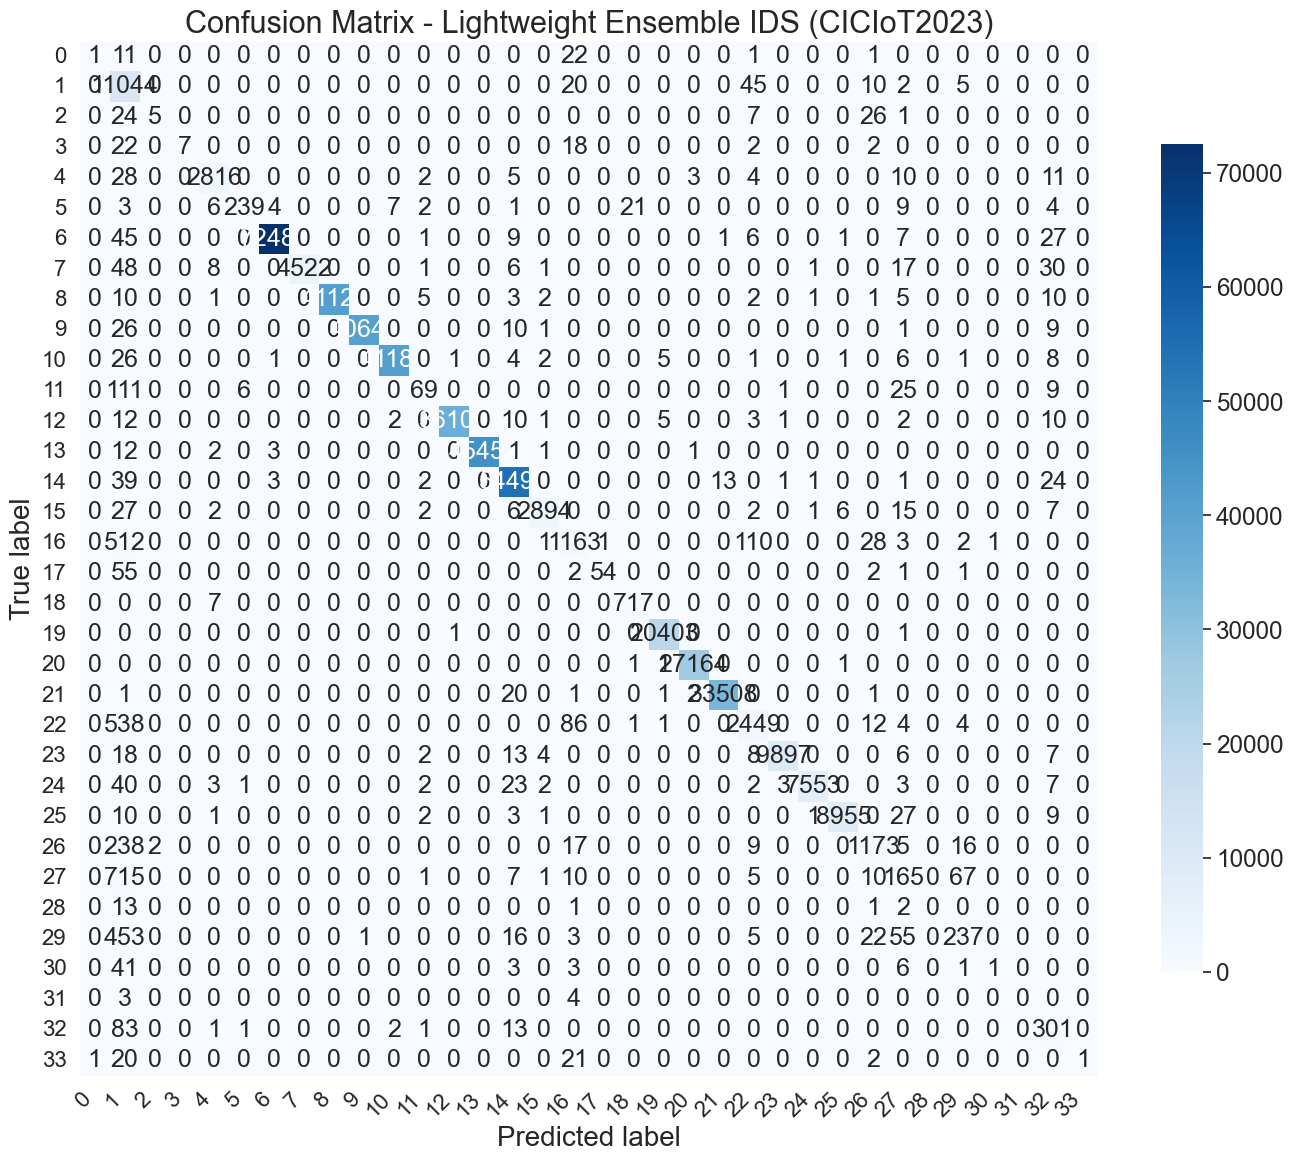

In [115]:
ensemble_clf = VotingClassifier(
    estimators=[
        ("dt", dt_model),
        ("rf", rf_model)
    ],
    voting="soft",   # mean vote
    n_jobs=-1
)
results['Ensemble Vote'] = evaluate_model('Ensemble Vote', ensemble_clf, X_train, y_train, X_test, y_test)

In [112]:
new_results = results.copy()
new_results.pop("Ensemble Vote", None)

print("Model Comparison")
print("-"*40)

comparison = pd.DataFrame({
    'Model': list(new_results.keys()),
    'Accuracy': [new_results[m]['accuracy'] for m in new_results],
    'F1': [new_results[m]['f1_score'] for m in new_results],
    'ROC-AUC': [new_results[m]['roc_auc'] for m in new_results],
    'CV': [new_results[m]['cv'] for m in new_results]
})

#comparison = comparison.sort_values('F1', ascending=False)
print('\n', comparison.to_string(index=False))

# Best model according to F1 score
best_model_name = comparison.iloc[0]['Model']
best_model_result = new_results[best_model_name]
best_model = best_model_result['model']

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {best_model_result['accuracy']:.4f}")
print(f"F1: {best_model_result['f1_score']:.4f}")
print(f"ROC-AUC: {best_model_result['roc_auc']:.4f}")
print(f"CV: {best_model_result['cv']:.4f}")

Model Comparison
----------------------------------------

         Model  Accuracy       F1  ROC-AUC       CV
Decision Tree  0.989414 0.989260 0.962084 0.989449
Random Forest  0.981181 0.979153 0.973154 0.975827

Best Model: Decision Tree
Accuracy: 0.9894
F1: 0.9893
ROC-AUC: 0.9621
CV: 0.9894


In [116]:
# VOTING CLASSIFIER
vote_soft = VotingClassifier(estimators=[('dt',dt_model),('rf',rf_model)], voting='soft')
vote_soft.fit(X_train, y_train)

# PREDICT
y_pred_vote = vote_soft.predict(X_test)

#enter data you want a prediction for
rf_predictions = rf_model.predict(X_test)
dt_predictions = dt_model.predict(X_test)
# rf_predictions

In [117]:
# SCORING
print("-"*60)
print("SOFT VOTING")
print("-"*60)

accur_score = accuracy_score(y_test, y_pred_vote)
print("Accuracy: ", accur_score)

prec_score = precision_score(y_test, y_pred_vote, average='weighted') # "ill-defined" Warning
print("Precision Score: ", prec_score)

recall = recall_score(y_test, y_pred_vote, average='weighted')
print("Recall Score: ", recall)

f1 = f1_score(y_test, y_pred_vote, average='weighted')
print("F1 Score: ", f1)

------------------------------------------------------------
SOFT VOTING
------------------------------------------------------------
Accuracy:  0.9903622176870172


C:\Users\Ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Precision Score:  0.9903839289841585
Recall Score:  0.9903622176870172
F1 Score:  0.9894660219531339


In [32]:
# VISUALIZATIONS
#decisionTree, filename, display specified columns & rules, output data in alphabetical order, writes info on graph, round box edges, color boxes
tree.export_graphviz(dt_model, out_file='IDS_IoT_decisionTree.dot', feature_names=X_test.columns, class_names=sorted(y.unique()), max_depth=3, label='all', rounded=True, filled=True)


In [33]:
rf_individual_tree = rf_model.estimators_[0] # grabs the first tree in the RandomForest
tree.export_graphviz(rf_individual_tree, out_file='IDS_IoT_rfTree.dot', feature_names=X_test.columns, class_names=sorted(y.unique()), max_depth=3, label='all', rounded=True, filled=True)
